In [1]:
from skimage.color import label2rgb, rgb2gray
from skimage.segmentation import mark_boundaries
import numpy as np
import tensorflow as tf
import os
import cv2
from glob import glob
import matplotlib.pyplot as plt
from keras.layers import *
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from skimage.morphology import binary_erosion, disk
import keras.backend as K
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from keras.callbacks import TensorBoard
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from keras.models import Model
from tqdm import tqdm
import glob

2024-01-27 20:04:34.358801: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-27 20:04:34.556596: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-27 20:04:35.380353: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-01-27 20:04:35.380448: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

In [2]:
# image_paths = glob.glob('/home/somayeh/PycharmProjects/superpixel_segmentation/archive (3)/data/Lung Segmentation/train_validation_original/*.png' )
# mask_paths = glob.glob('/home/somayeh/PycharmProjects/superpixel_segmentation/archive (3)/data/Lung Segmentation/train_validation_mask/*.png')
# image_paths = glob.glob('/home/somayeh/PycharmProjects/superpixel_segmentation/archive (2)/Dataset_BUSI_with_GT/breast_train/*.png')
# mask_paths = glob.glob('/home/somayeh/PycharmProjects/superpixel_segmentation/archive (2)/Dataset_BUSI_with_GT/breast_train_mask/*.png')
image_paths = glob.glob('/home/somayeh/PycharmProjects/superpixel_segmentation/new_data_breast/train/image/*.jpg')
mask_paths = glob.glob('/home/somayeh/PycharmProjects/superpixel_segmentation/new_data_breast/train/mask/*.jpg')

In [3]:
# initialize empty arrays to hold the images and masks
images = []
masks = []
images_superpixel = []
binary_masks = []
masks_superpixel = []
masks_result = []
binary = []

In [4]:
def extended_superpixel(img, ground_truth):
    # Perform SLIC superpixel segmentation
    num_segments = 1200
    segments = slic(img, n_segments=num_segments, compactness=10)


    # Find superpixels intersecting with the image boundaries
    boundary_mask = cv2.morphologyEx(ground_truth, cv2.MORPH_GRADIENT, np.ones((5, 5), np.uint8)) > 0
    boundary_superpixels = set(segments[boundary_mask])

    # Show the number of superpixels with intersection with image boundaries
    num_boundary_superpixels = len(boundary_superpixels)
    # print(f'The number of superpixels with intersection with image boundaries: {num_boundary_superpixels}')

    # Overlay superpixels with ground truth
    labels = segments.astype(np.int32)

    inside_mask = (ground_truth == 255)  # white pixels in ground truth are inside the chest region
    outside_mask = (ground_truth == 0)  # black pixels in ground truth are outside the chest region

    inside_superpixels = set(np.unique(labels[inside_mask]))
    outside_superpixels = set(np.unique(labels[outside_mask]))

    # Assign labels and color superpixels
    result = np.zeros_like(img)
    for label in outside_superpixels:
        mask = (labels == label)
        result[mask] = (0, 0, 0)  # Set label 0 (black) for superpixels outside the boundary

    for label in inside_superpixels:
        mask = (labels == label)
        result[mask] = (255, 255, 255)  # Set label 1 (white) for superpixels inside the boundary

    for label in boundary_superpixels:
        mask = (labels == label)
        num_pixels_inside = np.sum(mask & inside_mask)
        num_pixels_outside = np.sum(mask & outside_mask)

        if num_pixels_outside > num_pixels_inside:
            result[mask] = (0, 0, 0)  # Set label 0 (black) for superpixels with more pixels outside the boundary
        elif num_pixels_outside < num_pixels_inside:
            result[mask] = (255, 255, 255)  # Set label 1 (white) for superpixels with more pixels inside the boundary
        else:
            d1 = cv2.distanceTransform((mask & outside_mask).astype(np.uint8), cv2.DIST_L2, 5)
            d2 = cv2.distanceTransform((mask & inside_mask).astype(np.uint8), cv2.DIST_L2, 5)

            d1_sorted = np.sort(d1[mask & boundary_mask])
            d2_sorted = np.sort(d2[mask & boundary_mask])

            threshold_idx = len(d1_sorted) // 2
            if np.sum(d1_sorted[:threshold_idx]) > np.sum(d1_sorted[threshold_idx:]):
                result[mask] = (0, 0, 0)  # Set label 0 (black) for superpixels with larger distance to outside
            else:
                result[mask] = (255, 255, 255)  # Set label 1 (white) for superpixels with larger distance to inside

    # cv2.imshow('Result', result)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()

    return result

In [5]:
def iou(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    iou_score = (intersection + smooth) / (union + smooth)
    return iou_score

def precision(y_true, y_pred):
    y_true_flat = K.flatten(y_true)
    y_pred_flat = K.flatten(y_pred)
    true_positives = K.sum(K.round(K.clip(y_true_flat * y_pred_flat, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred_flat, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())

    return precision

def sensitivity(gt_mask, pred_mask):

    gt_mask_flat = K.flatten(gt_mask)
    pred_mask_flat = K.flatten(pred_mask)

    # compute true positive (TP) and false negative (FN) counts
    TP = K.sum(gt_mask_flat * pred_mask_flat)
    FN = K.sum(gt_mask_flat * (1 - pred_mask_flat))

    # compute sensitivity (recall)
    if TP + FN == 0:
        sensitivity_score = 0.0
    else:
        sensitivity_score = TP / (TP + FN)

    return sensitivity_score

def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2.0 * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [6]:
def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred, smooth=1)

In [7]:
batch_size = 8
threshold_value = 128
def data_generator(image_paths, mask_paths, batch_size):

    assert len(image_paths) == len(mask_paths), "Number of images and masks must be the same."

    num_samples = len(image_paths)
    print("Number of images:", num_samples)
    num_masks = len(mask_paths)
    print("Number of masks:", num_masks)

    while True:
        indices = np.arange(num_samples)
        np.random.shuffle(indices)

        for i in range(0, num_samples, batch_size):
            batch_indices = indices[i : i + batch_size]
            batch_images = []
            batch_masks = []

            for index in batch_indices:
                image_path = image_paths[index]
                mask_path = mask_paths[index]

                img = cv2.imread(image_path)
                img = cv2.resize(img, (128, 128))

                filename = os.path.join("/home/somayeh/PycharmProjects/superpixel_segmentation/"
                                        "newgt/newgt_extended_superpixel_breast_128_slic1200", os.path.basename(mask_path))
                if not os.path.exists(filename):

                    mask = cv2.imread(mask_path,0)
                    mask = cv2.resize(mask, (128, 128))

                    result = extended_superpixel(img, mask)
                    # result = ground_truth_superpixel_3(img, mask)

                    # result = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)
                    # plt.subplot(1, 2, 2)
                    # plt.imshow(result)
                    # plt.title("hggh")

                    # soft_label = binary_to_soft_label(result, threshold_value=threshold_value)
                    # cv2.imshow("kjkj",soft_label)
                    # cv2.waitKey(0)
                    # result = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)

                    cv2.imwrite(filename, result)

                else:
                    result = cv2.imread(filename, 0)
                # print(result.type)
                # img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                # soft_label = binary_to_soft_label(result)

                # normalize the image and mask to have values between 0 and 1
                # img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                img = img / 255.0
                result= result/ 255.0
                # result = result / 255.0
                # print(soft_label.shape)
                # cv2.imshow("dfg", soft_label)
                # cv2.waitKey(0)
                # Append the preprocessed data to the respective lists

                batch_images.append(img)
                batch_masks.append(result)

            # Yield the batch data
            batch_images = np.array(batch_images)
            batch_masks = np.array(batch_masks)

            # Visualize the images and masks in the batch
            # for j in range(batch_images.shape[0]):
            #     plt.subplot(1, 2, 1)
            #     plt.imshow(batch_images[j])
            #     plt.title("Image")
            #
            #     plt.subplot(1, 2, 2)
            #     plt.imshow(batch_masks[j])
            #     plt.title("Mask")
            #
            #     plt.show()

            yield batch_images, batch_masks

# 
# generator = data_generator(image_paths, mask_paths, 1)
# 
# for _,imgpath in tqdm(enumerate(image_paths)):
#    batch = next(generator)

In [8]:
mask_path_superpixel_label = glob.glob("/home/somayeh/PycharmProjects/superpixel_segmentation/newgt/newgt_extended_superpixel_breast_128_slic1200/*.jpg")

In [9]:
assert len(image_paths) == len(mask_path_superpixel_label), "Number of images and masks must be the same."
# Split the data into training and validation sets
train_image_paths, val_image_paths, train_mask_paths, val_mask_paths = train_test_split(
    image_paths, mask_path_superpixel_label, test_size=0.2, random_state=2023
)


# Create separate generators for training and validation sets
train_generator = data_generator(train_image_paths, train_mask_paths, batch_size)
val_generator = data_generator(val_image_paths, val_mask_paths, batch_size)

# batch_size = 5  # Number of batches to visualize

# for _ in range(batch_size):
#     batch = next(train_generator)

# Determine the number of steps per epoch for training and validation
train_steps_per_epoch = len(train_image_paths) // batch_size
val_steps_per_epoch = len(val_image_paths) // batch_size

print(train_steps_per_epoch)
print(val_steps_per_epoch)

1294
323


In [10]:
from keras.applications import MobileNetV2

IMAGE_SIZE = 128
# Function for conv2d_block (to be used for building decoder of unet)
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size), kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def unet(n_filters=16, batchnorm=True, dropout=0.1, num_classes=1):
    # Contracting Path (encoder)
    inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name="input_image")
    encoder = MobileNetV2(input_tensor=inputs, include_top=False)

    BASE_WEIGHT_PATH = ('https://github.com/fchollet/deep-learning-models/releases/download/v0.6/')
    model_name = 'mobilenet_%s_%d_tf_no_top.h5' % ('1_0', 224)
    weight_path = BASE_WEIGHT_PATH + model_name
    weights_path = tf.keras.utils.get_file(model_name, weight_path)

    encoder.load_weights(weights_path, by_name=True, skip_mismatch=True)

    skip_connection_names = ["input_image", "block_1_expand_relu", "block_3_expand_relu", "block_6_expand_relu"]
    encoder_output = encoder.get_layer("block_13_expand_relu").output

    x = encoder_output
    x_skip_1 = encoder.get_layer(skip_connection_names[-1]).output
    x_skip_2 = encoder.get_layer(skip_connection_names[-2]).output
    x_skip_3 = encoder.get_layer(skip_connection_names[-3]).output
    x_skip_4 = encoder.get_layer(skip_connection_names[-4]).output

    # Expansive Path (decoder)
    u6 = Conv2DTranspose(n_filters * 13, (3, 3), strides=(2, 2), padding='same')(x)
    u6 = concatenate([u6, x_skip_1])
    c6 = conv2d_block(u6, n_filters * 13, kernel_size=3, batchnorm=batchnorm)
    p6 = Dropout(dropout)(c6)

    u7 = Conv2DTranspose(n_filters * 12, (3, 3), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, x_skip_2])
    c7 = conv2d_block(u7, n_filters * 12, kernel_size=3, batchnorm=batchnorm)
    p7 = Dropout(dropout)(c7)

    u8 = Conv2DTranspose(n_filters * 11, (3, 3), strides=(2, 2), padding='same')(p7)
    u8 = concatenate([u8, x_skip_3])
    c8 = conv2d_block(u8, n_filters * 11, kernel_size=3, batchnorm=batchnorm)
    p7 = Dropout(dropout)(c8)

    u9 = Conv2DTranspose(n_filters * 10, (3, 3), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, x_skip_4])
    c9 = conv2d_block(u9, n_filters * 10, kernel_size=3, batchnorm=batchnorm)

    # Output layer with sigmoid activation for binary segmentation
    outputs = Conv2D(num_classes, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=inputs, outputs=outputs)

    return model

In [11]:
!rm -rf '/home/somayeh/PycharmProjects/superpixel_segmentation/tensor_board'

In [12]:
%load_ext tensorboard
log_folder = '/home/somayeh/PycharmProjects/superpixel_segmentation/tensor_board'

In [13]:
# weight_path="{}_Unet_extended_superpixel_chest_slic800.best.hdf5".format('cxr_reg')
weight_path="{}_Unet_extended_superpixel_breast_slic800.best.hdf5".format('cxr_reg')


checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1,
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                   patience=3,
                                   verbose=1, mode='min', epsilon=0.0001, cooldown=2, min_lr=1e-5)
early = EarlyStopping(monitor="val_loss",
                      mode="min",
                      patience=20) # probably needs to be more patient, but kaggle time is limited

tbcallback = TensorBoard(log_dir=log_folder,
                         histogram_freq=1,
                         write_graph=True,
                         write_images=True,
                         update_freq='epoch',
                         profile_batch=2,
                         embeddings_freq=1)

callbacks_list = [checkpoint, early, reduceLROnPlat, tbcallback]

2024-01-27 20:06:06.511037: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2024-01-27 20:06:06.511071: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.
2024-01-27 20:06:06.587622: I tensorflow/core/profiler/backends/gpu/cupti_tracer.cc:1664] Profiler found 1 GPUs
2024-01-27 20:06:06.588241: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcupti.so.11.2'; dlerror: libcupti.so.11.2: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/somayeh/PycharmProjects/superpixel_segmentation/venv/lib/python3.8/site-packages/cv2/../../lib64:
2024-01-27 20:06:06.639505: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.
2024-01-27 20:06:06.639633: I tensorflow/core/profiler/backends/gpu/cupti_tracer.cc:1798] CUPTI activity buffer flushed


In [14]:
model =unet(n_filters = 8, batchnorm = True, dropout = 0.1, num_classes=1)
opt = tf.keras.optimizers.experimental.AdamW(learning_rate=0.0001)
model.compile(optimizer=opt, loss=dice_loss, metrics= [dice_coef, precision, sensitivity, iou],  run_eagerly=True)
model.summary()

2024-01-27 20:06:11.903556: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-27 20:06:12.006468: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-27 20:06:12.006646: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-27 20:06:12.007504: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operati

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_image[0][0]']            
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 64, 64, 32)   0           ['bn_Conv1[0][0]']           

In [15]:
loss_history = model.fit_generator(
    train_generator,
    steps_per_epoch=train_steps_per_epoch,
    validation_data=val_generator,
    validation_steps=val_steps_per_epoch,
    epochs=50,
    callbacks =callbacks_list
)

# model.save("unet_extended_superpixel_chest_slic800.h5")
model.save("unet_extended_superpixel_breast_slic800.h5")


Number of images: 10358
Number of masks: 10358
Epoch 1/50


/tmp/ipykernel_5253/3604466995.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  loss_history = model.fit_generator(
2024-01-27 20:06:36.827620: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8902
2024-01-27 20:06:37.662724: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2024-01-27 20:06:37.663865: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:234] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2024-01-27 20:06:37.663894: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:237] Used ptxas at ptxas
2024

2024-01-27 20:06:39.975380: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2024-01-27 20:06:40.066139: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2024-01-27 20:06:40.214160: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-addr

   1/1294 [..............................] - ETA: 4:56:41 - loss: 0.8847 - dice_coef: 0.1153 - precision: 0.0644 - sensitivity: 0.5352 - iou: 0.0612

2024-01-27 20:06:49.055490: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2024-01-27 20:06:49.167331: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2024-01-27 20:06:49.167352: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.


   2/1294 [..............................] - ETA: 15:22 - loss: 0.8303 - dice_coef: 0.1697 - precision: 0.1038 - sensitivity: 0.5390 - iou: 0.0937  

2024-01-27 20:06:49.787144: I tensorflow/core/profiler/lib/profiler_session.cc:67] Profiler session collecting data.
2024-01-27 20:06:49.803872: I tensorflow/core/profiler/backends/gpu/cupti_tracer.cc:1798] CUPTI activity buffer flushed
2024-01-27 20:06:49.853654: I tensorflow/core/profiler/backends/gpu/cupti_collector.cc:522]  GpuTracer has collected 1645 callback api events and 1742 activity events. 
2024-01-27 20:06:49.866164: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.
2024-01-27 20:06:49.867790: I tensorflow/core/profiler/rpc/client/save_profile.cc:164] Collecting XSpace to repository: /home/somayeh/PycharmProjects/superpixel_segmentation/tensor_board/plugins/profile/2024_01_27_20_06_49/somayeh-ASUS-TUF-Gaming-F15-FX506HCB-FX506HCB.xplane.pb


1294/1294 [==============================] - ETA: 0s - loss: 0.3374 - dice_coef: 0.6626 - precision: 0.6939 - sensitivity: 0.7742 - iou: 0.5166Number of images: 2590
Number of masks: 2590

Epoch 1: val_loss improved from inf to 0.36031, saving model to cxr_reg_Unet_extended_superpixel_breast_slic800.best.hdf5
1294/1294 [==============================] - 250s 183ms/step - loss: 0.3374 - dice_coef: 0.6626 - precision: 0.6939 - sensitivity: 0.7742 - iou: 0.5166 - val_loss: 0.3603 - val_dice_coef: 0.6397 - val_precision: 0.8955 - val_sensitivity: 0.5467 - val_iou: 0.4852 - lr: 1.0000e-04
Epoch 2/50
1294/1294 [==============================] - ETA: 0s - loss: 0.1945 - dice_coef: 0.8056 - precision: 0.8442 - sensitivity: 0.8090 - iou: 0.6853
Epoch 2: val_loss improved from 0.36031 to 0.21689, saving model to cxr_reg_Unet_extended_superpixel_breast_slic800.best.hdf5
1294/1294 [==============================] - 235s 181ms/step - loss: 0.1945 - dice_coef: 0.8056 - precision: 0.8442 - sensitivit

In [16]:
test_images = []
ground_truth_test_images = []

# test_paths = glob.glob("/home/somayeh/PycharmProjects/superpixel_segmentation/archive (3)/data/Lung Segmentation/test_original/*.png")
# test_mask_paths = glob.glob("/home/somayeh/PycharmProjects/superpixel_segmentation/archive (3)/data/Lung Segmentation/test_mask/*.png")
test_paths = glob.glob("/home/somayeh/PycharmProjects/superpixel_segmentation/archive (2)/Dataset_BUSI_with_GT/breast_test/*.png")
test_mask_paths = glob.glob("/home/somayeh/PycharmProjects/superpixel_segmentation/archive (2)/Dataset_BUSI_with_GT/breast_test_mask/*.png")

In [17]:
# model.load_weights("{}_Unet_extended_superpixel_chest_slic800.best.hdf5".format('cxr_reg'))
model.load_weights("{}_Unet_extended_superpixel_breast_slic800.best.hdf5".format('cxr_reg'))


In [18]:
dice_scores = []  # List to store the dice coefficients
precision_scores = []
sensitivity_scores = []
iou_scores = []

(69, 128, 128, 3)
(69, 128, 128)


/home/somayeh/PycharmProjects/superpixel_segmentation/venv/lib/python3.8/site-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


69/69 [==============================] - 3s 32ms/step
(69, 128, 128, 1)
(69, 128, 128, 1)
(69, 128, 128)
Dices: [<tf.Tensor: shape=(), dtype=float64, numpy=0.6570464457887377>, <tf.Tensor: shape=(), dtype=float64, numpy=0.22199703957834743>, <tf.Tensor: shape=(), dtype=float64, numpy=0.9445649622680428>, <tf.Tensor: shape=(), dtype=float64, numpy=0.334524796018298>, <tf.Tensor: shape=(), dtype=float64, numpy=0.1135433300623355>, <tf.Tensor: shape=(), dtype=float64, numpy=0.9014755610205963>, <tf.Tensor: shape=(), dtype=float64, numpy=0.8835715968524712>, <tf.Tensor: shape=(), dtype=float64, numpy=0.892215351367058>, <tf.Tensor: shape=(), dtype=float64, numpy=0.9323459331425268>, <tf.Tensor: shape=(), dtype=float64, numpy=0.8924111354938568>, <tf.Tensor: shape=(), dtype=float64, numpy=0.913212138822803>, <tf.Tensor: shape=(), dtype=float64, numpy=0.7806688508295242>, <tf.Tensor: shape=(), dtype=float64, numpy=0.7503492681999621>, <tf.Tensor: shape=(), dtype=float64, numpy=0.824004710482

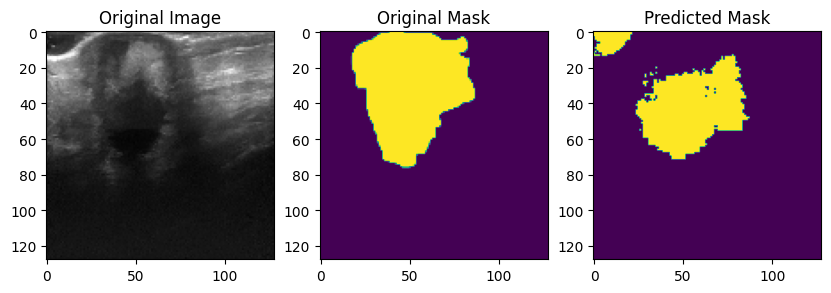

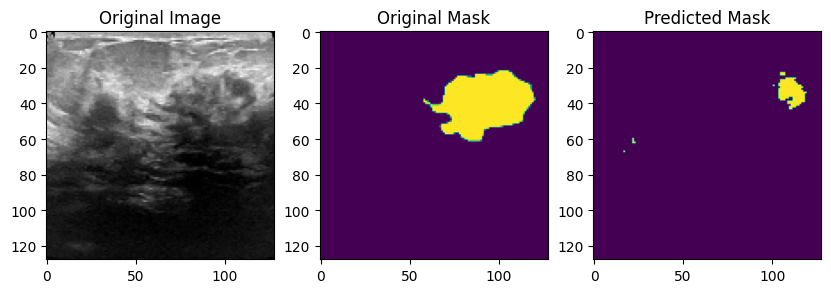

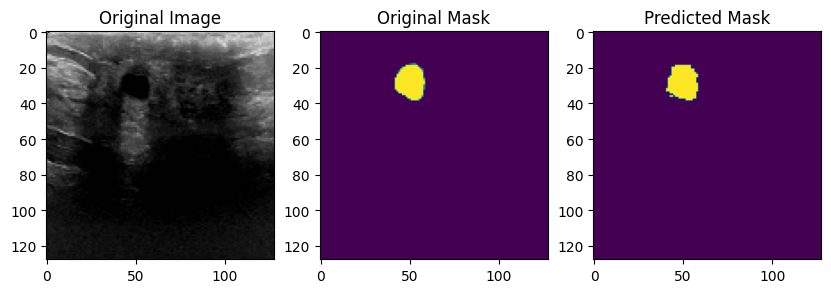

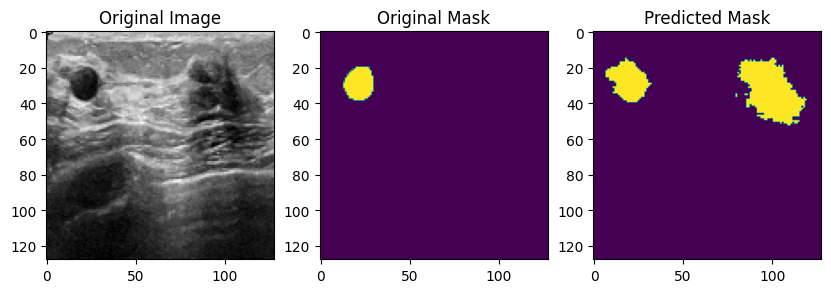

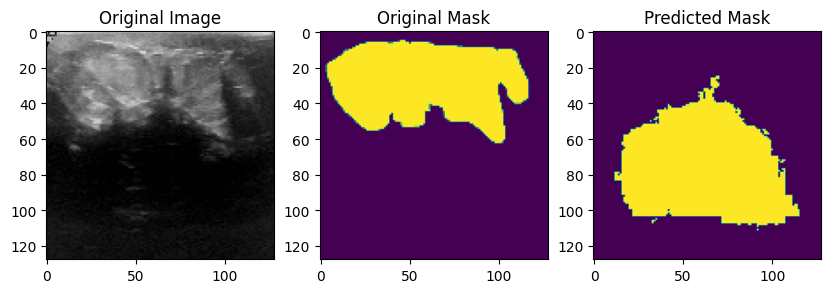

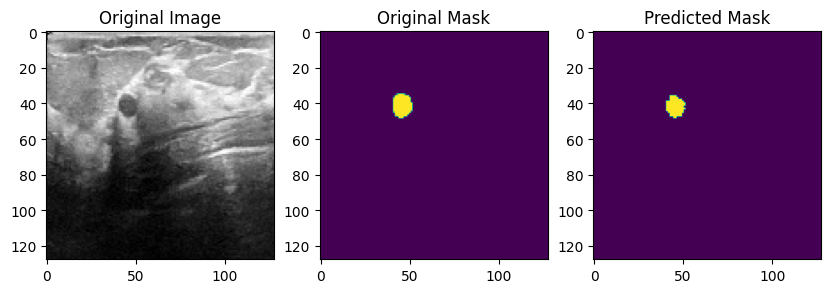

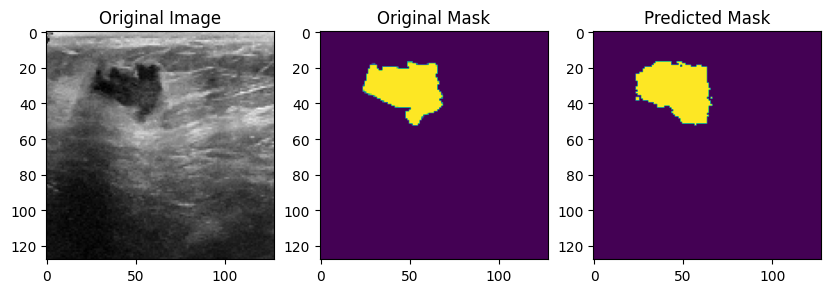

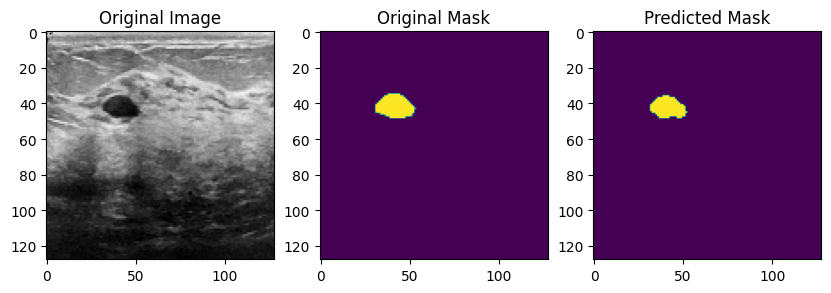

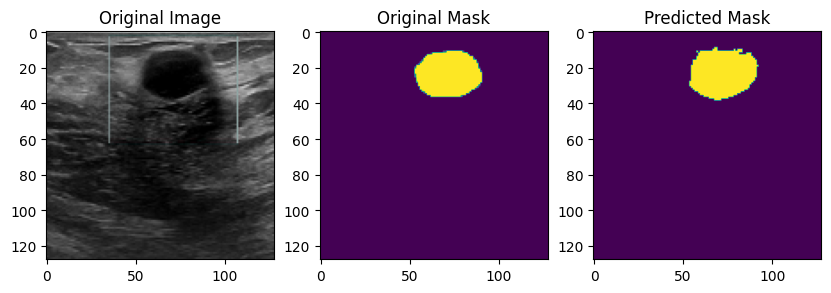

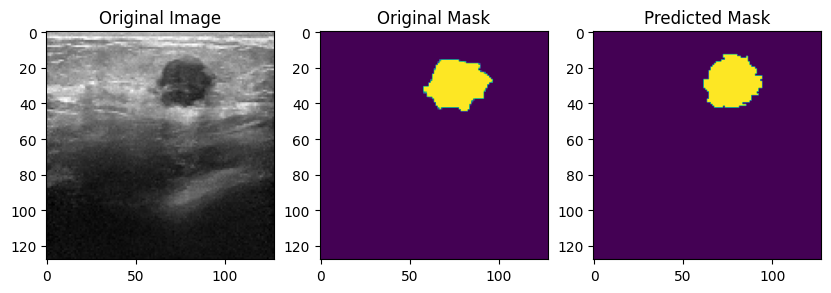

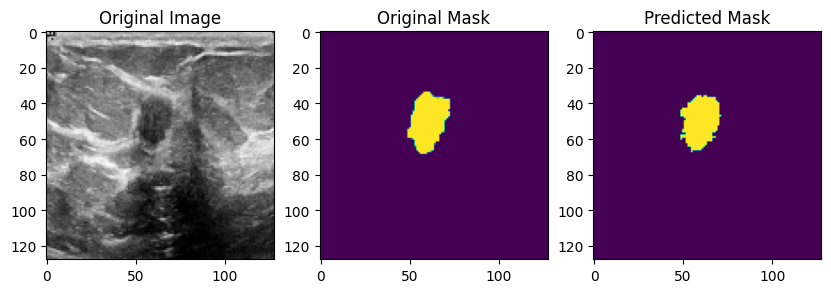

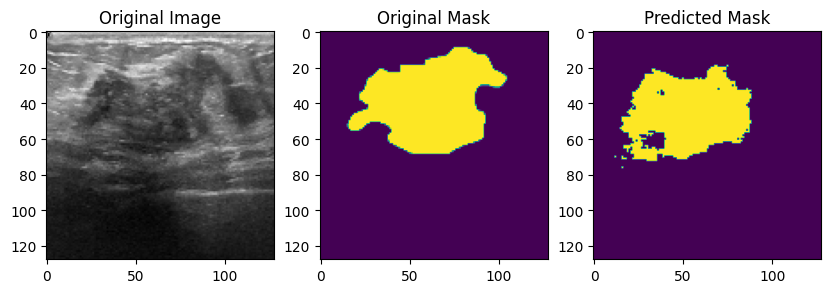

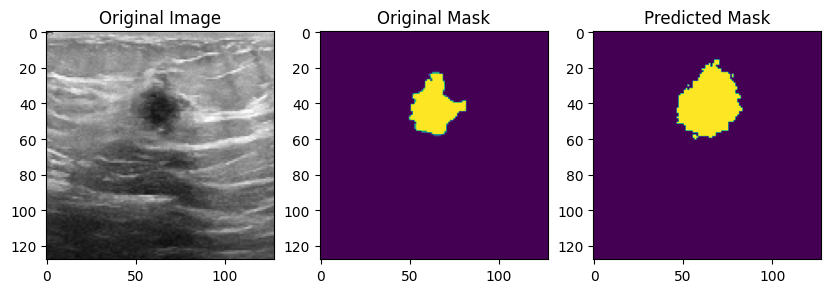

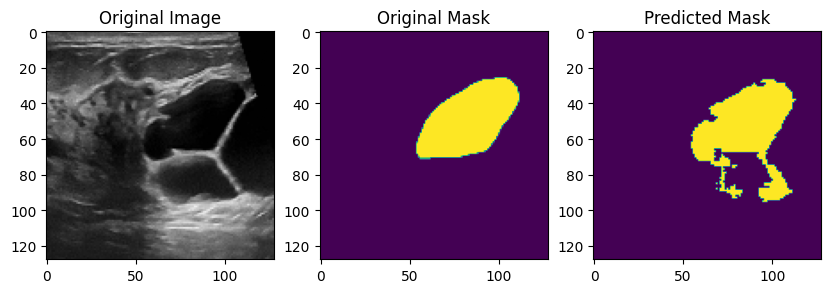

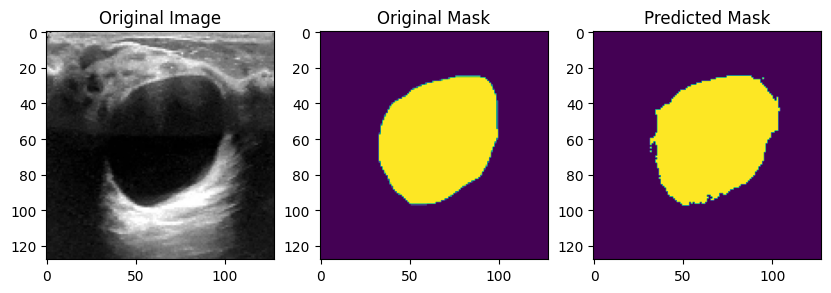

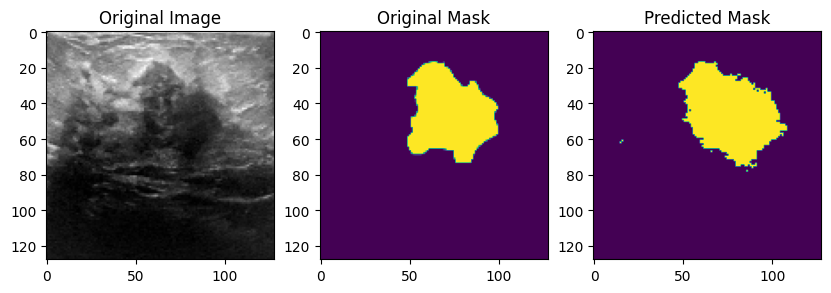

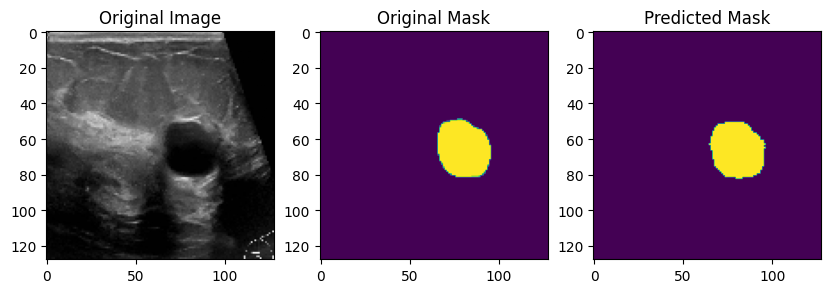

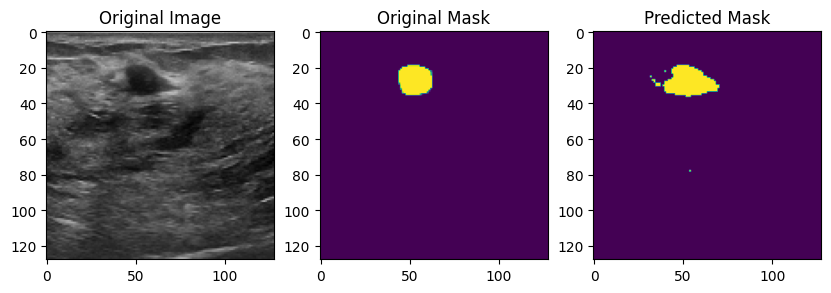

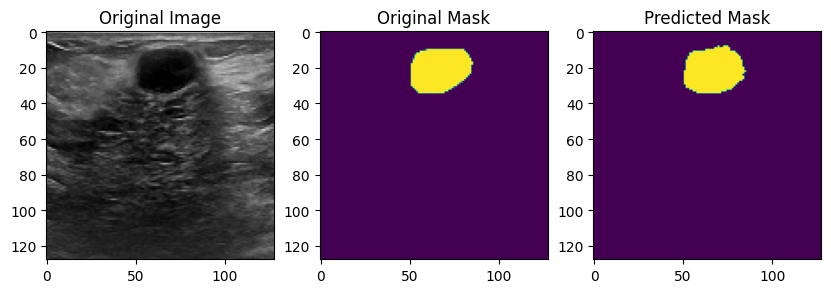

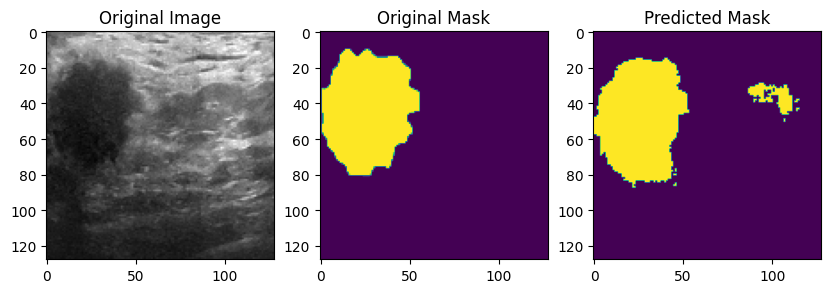

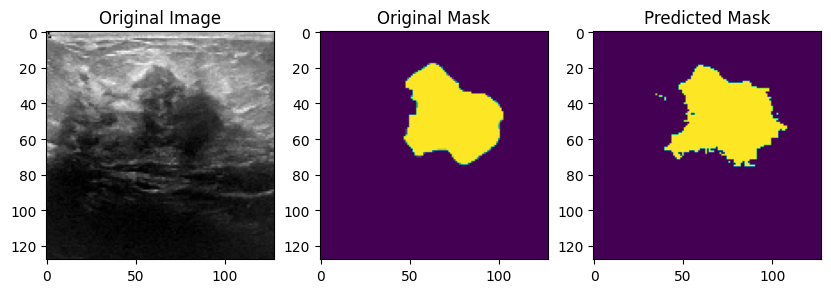

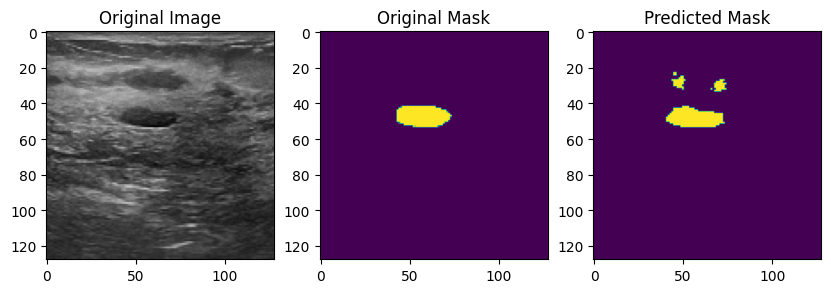

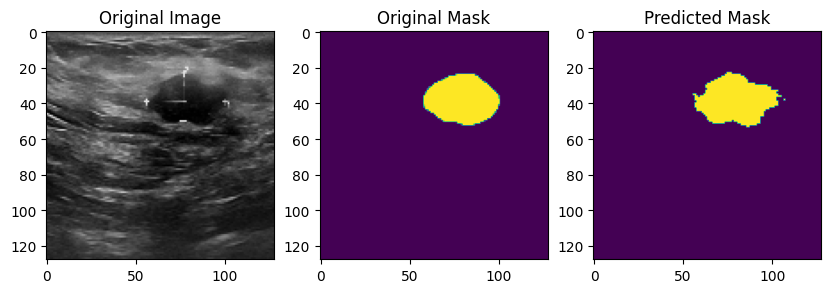

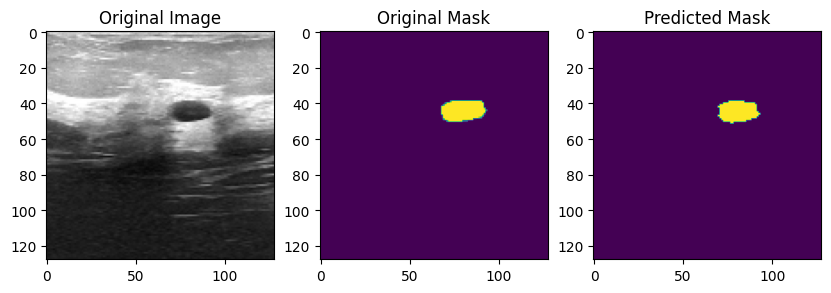

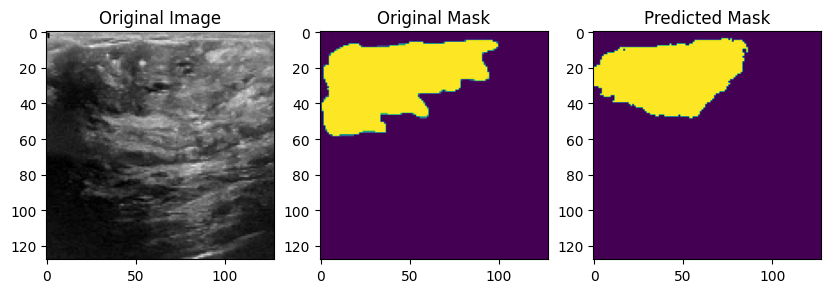

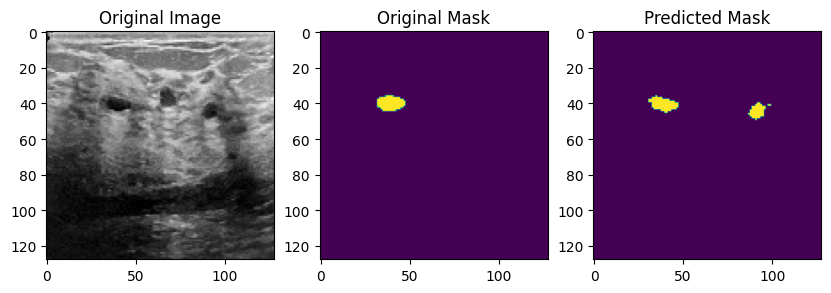

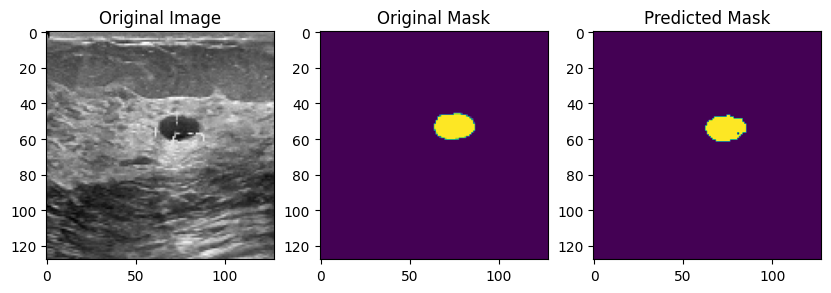

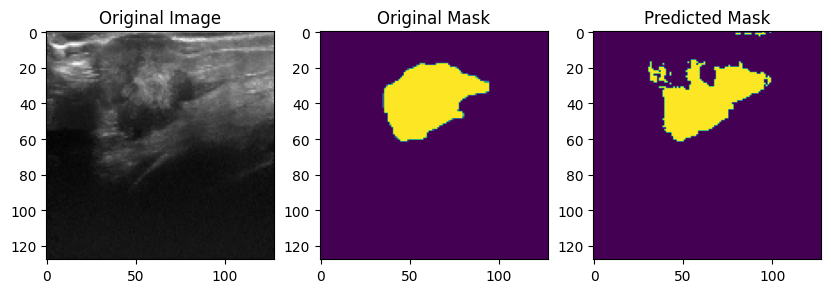

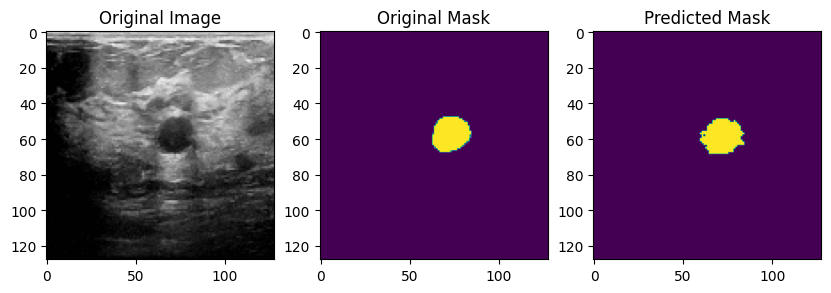

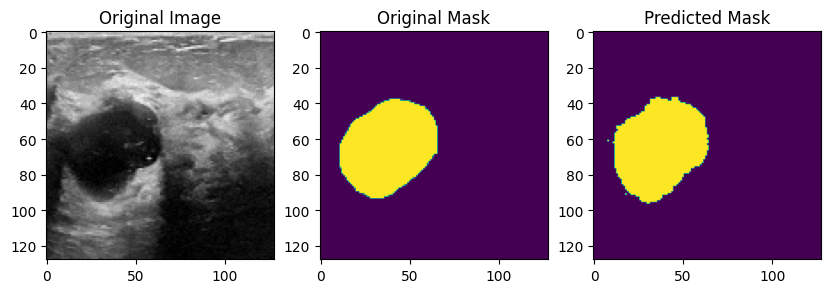

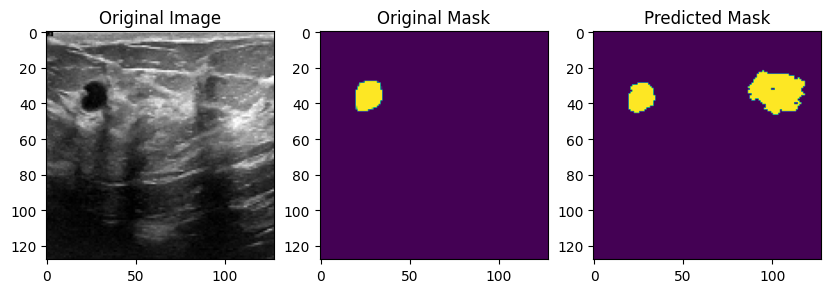

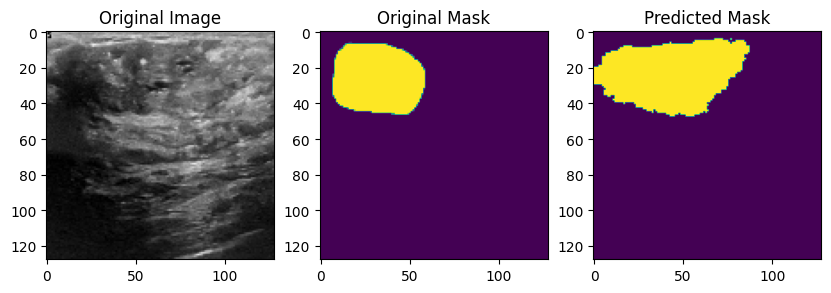

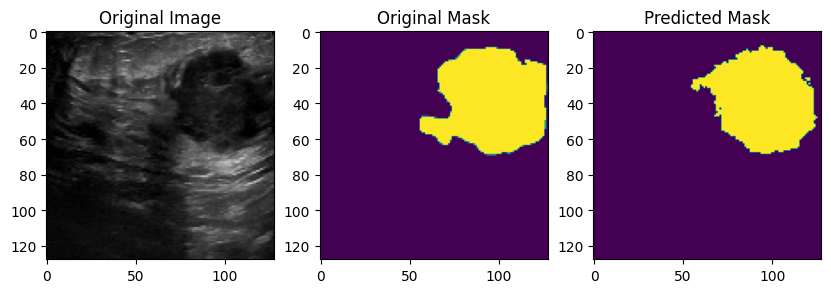

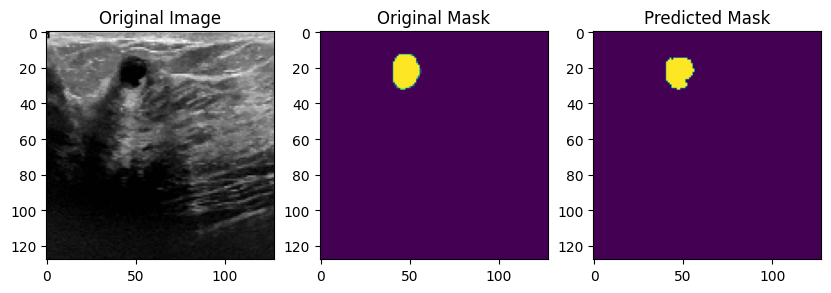

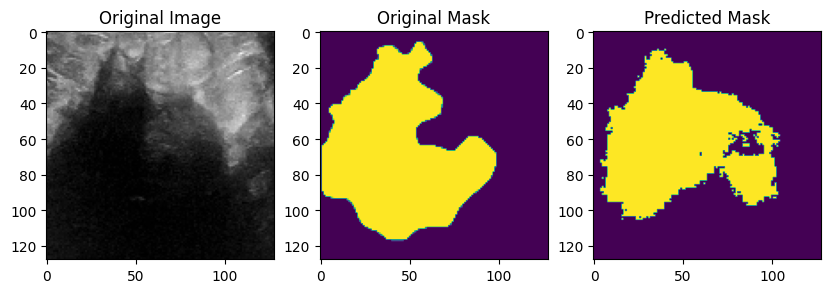

In [19]:
for test_path, test_mask_path in zip(test_paths, test_mask_paths):
    # read the image and mask using OpenCV
    test_image = cv2.imread(test_path)
    ground_truth_test_image = cv2.imread(test_mask_path, 0)  # read the mask as grayscale

    # resize the image and mask to the desired dimensions
    test_image = cv2.resize(test_image, (128, 128))
    ground_truth_test_image = cv2.resize(ground_truth_test_image, (128, 128))

# normalize the image and mask to have values between 0 and 1

    test_image = test_image / 255.0
    ground_truth_test_image= ground_truth_test_image / 255.0

    # add the image and mask to the corresponding arrays
    test_images.append(test_image)
    ground_truth_test_images.append(ground_truth_test_image)


#by the end of this line, I have superpixeled images.
# convert the images and masks to numpy arrays
test_images = np.array(test_images)
ground_truth_test_images = np.array(ground_truth_test_images)
print(test_images.shape)
print(ground_truth_test_images.shape)
# add a channel dimension to the masks
# ground_truth_test_images = np.expand_dims(ground_truth_test_images, axis=-1)


# Make predictions
# predicted_masks = model.predict(test_images)
tf.config.run_functions_eagerly(True)
predicted_masks = model.predict(
    test_images,
    batch_size=1,
    verbose=1,
    steps=None,
    callbacks=None
)

predicted_mask_array = np.array(predicted_masks)
print(predicted_mask_array.shape)

# Convert the NumPy array to uint8 format
predicted_mask_array = (predicted_mask_array * 255).astype(np.uint8)
print(predicted_mask_array.shape)

#
dst = np.empty([predicted_mask_array.shape[0],predicted_mask_array.shape[1],predicted_mask_array.shape[2]])
kernel = np.ones((5,5),np.float64)/25
# dst = predicted_mask_array

#
for i in range(predicted_mask_array.shape[0]):

        threshold_value = 1
        _, dst[i] = cv2.threshold(predicted_mask_array[i], threshold_value, 255, cv2.THRESH_BINARY)
        dst[i] = np.array(dst[i])
        dst[i] = tf.convert_to_tensor(dst[i] / 255.0,dtype=predicted_masks.dtype)

print(dst.shape)

## Cast the input tensor to a double tensor
ground_truth_test_images = tf.cast(ground_truth_test_images, dtype=tf.float64)
predicted_masks = tf.cast(dst, dtype=tf.float64)
# predicted_masks = tf.cast(predicted_mask_array, dtype=tf.float64)
# Apply thresholding

dice_scores = []  # List to store the dice coefficients
precision_scores = []
sensitivity_scores = []
iou_scores = []

# Iterate over the images and calculate the dice coefficient
for i in range(len(ground_truth_test_images)):
    y_true = ground_truth_test_images[i]
    y_pred = predicted_masks[i]

    dice = dice_coef(y_true, y_pred)
    dice_scores.append(dice)

# Compute the average dice coefficient
average_dice = np.mean(dice_scores)

for i in range(len(ground_truth_test_images)):
    y_true = ground_truth_test_images[i]
    y_pred = predicted_masks[i]

    precision_value = precision(y_true, y_pred)
    precision_scores.append(precision_value)

# Compute the average dice coefficient
average_precision = np.mean(precision_scores)

for i in range(len(ground_truth_test_images)):
    y_true = ground_truth_test_images[i]
    y_pred = predicted_masks[i]

    sensitivity_value = sensitivity(y_true, y_pred)
    sensitivity_scores.append(sensitivity_value)

# Compute the average dice coefficient
average_sensitivity = np.mean(sensitivity_scores)

for i in range(len(ground_truth_test_images)):
    y_true = ground_truth_test_images[i]
    y_pred = predicted_masks[i]

    iou_value = iou(y_true, y_pred)
    iou_scores.append(iou_value)

# Compute the average dice coefficient
average_iou = np.mean(iou_scores)


print("Dices:", dice_scores)
print("Dice coefficient:", average_dice)
print("Precision:", average_precision)
print("Sensitivity:", average_sensitivity)
print("IoU:", average_iou)

n =35 # number of images to show
for i in range(n):
    fig, ax = plt.subplots(1, 3, figsize=(10, 5))
    ax[0].imshow(test_images[i])
    ax[0].set_title('Original Image')
    ax[1].imshow(ground_truth_test_images[i])
    ax[1].set_title('Original Mask')
    ax[2].imshow(dst[i])
    ax[2].set_title('Predicted Mask')
    plt.show()